In [ ]:
import importlib
import ibkr_import
importlib.reload(ibkr_import)



from ibkr_import import IBKRConfig, connect_ibkr, fetch_pair

# Configure your pair here
PAIR = ("AMT", "CCI")
START = "2023-10-01 00:00:00"
END = "2025-10-01 00:00:00"

cfg = IBKRConfig(client_id=13)   # pick any unused clientId
ib = connect_ibkr(cfg)

prices = fetch_pair(
    ib,
    PAIR,
    START,
    END,
    cfg
)

# Extract ticker names and series for use in rest of notebook
TICKER1, TICKER2 = PAIR
stock1 = prices[TICKER1]
stock2 = prices[TICKER2]

prices.head()


=== Fetching AMT ===
[AMT] req 001 |  106 bars | 2025-09-24 09:30:00-04:00 → 2025-09-30 09:45:00-04:00
[AMT] req 002 |  130 bars | 2025-09-17 09:30:00-04:00 → 2025-09-23 15:45:00-04:00
[AMT] req 003 |  130 bars | 2025-09-10 09:30:00-04:00 → 2025-09-16 15:45:00-04:00
[AMT] req 004 |  130 bars | 2025-09-03 09:30:00-04:00 → 2025-09-09 15:45:00-04:00
[AMT] req 005 |  104 bars | 2025-08-27 09:30:00-04:00 → 2025-09-02 15:45:00-04:00
[AMT] req 006 |  130 bars | 2025-08-20 09:30:00-04:00 → 2025-08-26 15:45:00-04:00
[AMT] req 007 |  130 bars | 2025-08-13 09:30:00-04:00 → 2025-08-19 15:45:00-04:00
[AMT] req 008 |  130 bars | 2025-08-06 09:30:00-04:00 → 2025-08-12 15:45:00-04:00
[AMT] req 009 |  130 bars | 2025-07-30 09:30:00-04:00 → 2025-08-05 15:45:00-04:00
[AMT] req 010 |  130 bars | 2025-07-23 09:30:00-04:00 → 2025-07-29 15:45:00-04:00
[AMT] req 011 |  130 bars | 2025-07-16 09:30:00-04:00 → 2025-07-22 15:45:00-04:00
[AMT] req 012 |  130 bars | 2025-07-09 09:30:00-04:00 → 2025-07-15 15:45:00-

,AMT,CCI
date,,
2023-10-02 09:30:00-04:00,163.38,91.36
2023-10-02 09:45:00-04:00,163.02,91.84
2023-10-02 10:00:00-04:00,162.77,91.83
2023-10-02 10:15:00-04:00,162.45,91.82
2023-10-02 10:30:00-04:00,162.54,91.31


Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; usfarm.nj; jfarm; usfuture; afarm; cashfarm; eufarmnj; usfarm; euhmds; cashhmds; fundfarm; ushmds; secdefil.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; usfarm.nj; jfarm; usfuture; afarm; cashfarm; eufarmnj; usfarm; euhmds; cashhmds; fundfarm; ushmds; secdefil.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; usf

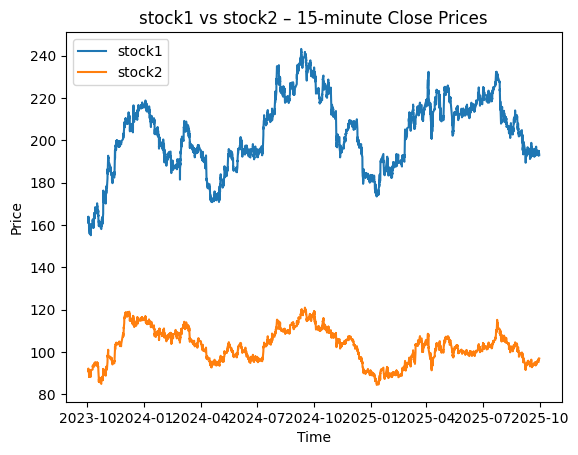

In [54]:
# Plotting normal prices

import matplotlib.pyplot as plt

plt.figure()
plt.plot(prices.index, prices["AMT"], label="stock1")
plt.plot(prices.index, prices["CCI"], label="stock2")
plt.legend()
plt.title("stock1 vs stock2 – 15-minute Close Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

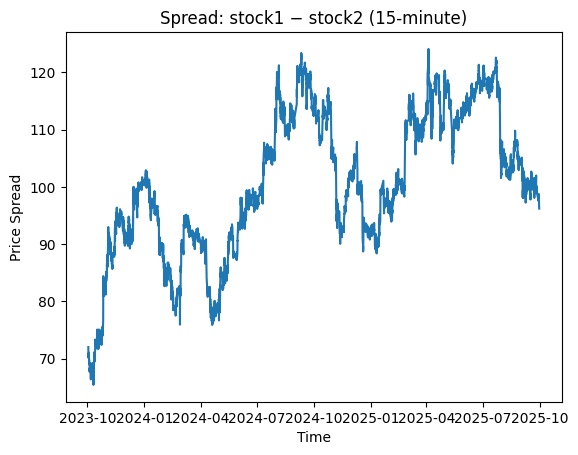

In [55]:
# Define the series from your dataframe
stock1 = prices["AMT"]
stock2 = prices["CCI"]   # Bank of America

spread = stock1 - stock2

plt.figure()
plt.plot(spread.index, spread)
plt.title("Spread: stock1 − stock2 (15-minute)")
plt.xlabel("Time")
plt.ylabel("Price Spread")
plt.show()


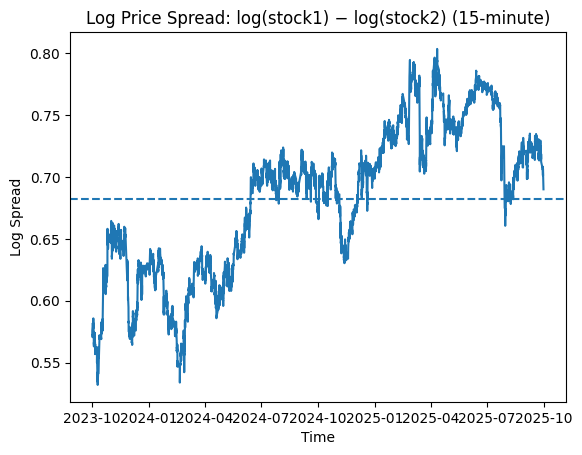

In [56]:
import numpy as np

log_spread = np.log(stock1) - np.log(stock2)

plt.figure()
plt.plot(log_spread.index, log_spread)
plt.axhline(log_spread.mean(), linestyle="--")
plt.title("Log Price Spread: log(stock1) − log(stock2) (15-minute)")
plt.xlabel("Time")
plt.ylabel("Log Spread")
plt.show()

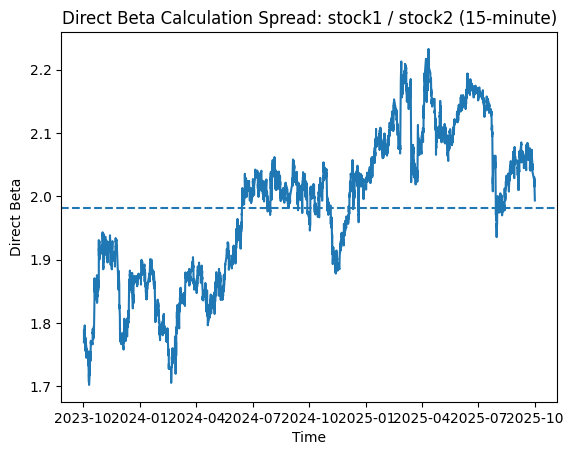

In [57]:
beta_direct = stock1/stock2

plt.figure()
plt.plot(beta_direct.index, beta_direct)
plt.axhline(beta_direct.mean(), linestyle="--")
plt.title("Direct Beta Calculation Spread: stock1 / stock2 (15-minute)")
plt.xlabel("Time")
plt.ylabel("Direct Beta")
plt.show()

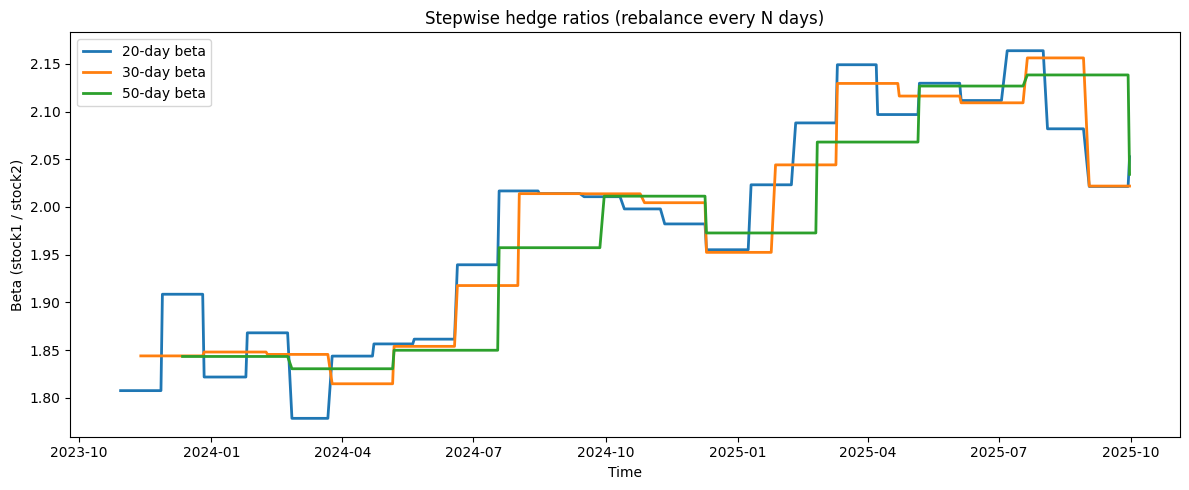

In [58]:
# daily close ratio
daily_ratio = (stock1 / stock2).resample("1D").last().dropna()

def step_beta(daily_ratio, N):
    beta_hat = daily_ratio.rolling(N).mean()
    mask = np.zeros(len(beta_hat), dtype=bool)
    mask[::N] = True                 # rebalance every N days
    return beta_hat.where(mask).ffill()

beta_20 = step_beta(daily_ratio, 20)
beta_30 = step_beta(daily_ratio, 30)
beta_50 = step_beta(daily_ratio, 50)

# plot
plt.figure(figsize=(12, 5))
plt.plot(beta_20.index, beta_20, label="20-day beta", linewidth=2)
plt.plot(beta_30.index, beta_30, label="30-day beta", linewidth=2)
plt.plot(beta_50.index, beta_50, label="50-day beta", linewidth=2)

plt.title("Stepwise hedge ratios (rebalance every N days)")
plt.xlabel("Time")
plt.ylabel("Beta (stock1 / stock2)")
plt.legend()
plt.tight_layout()
plt.show()


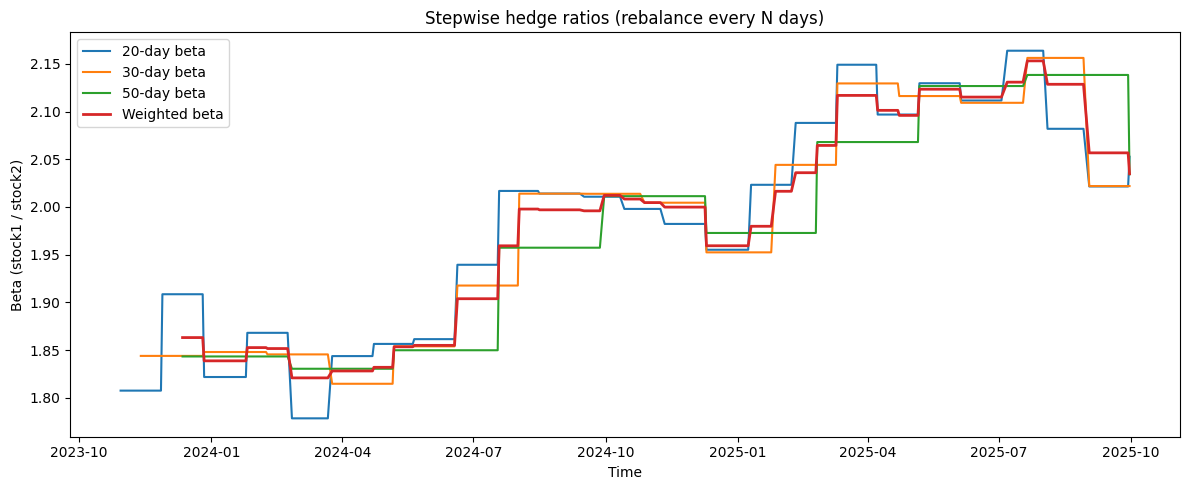

Beta window weightings : (0.3, 0.4, 0.3)


In [59]:
beta_weights = (0.3,0.4,0.3)

weighted_beta = beta_20 * beta_weights[0] +  beta_30 * beta_weights[1] + beta_50 * beta_weights[2]
# plot
plt.figure(figsize=(12, 5))
plt.plot(beta_20.index, beta_20, label="20-day beta", linewidth=1.5)
plt.plot(beta_30.index, beta_30, label="30-day beta", linewidth=1.5)
plt.plot(beta_50.index, beta_50, label="50-day beta", linewidth=1.5)
plt.plot(weighted_beta.index, weighted_beta, label="Weighted beta", linewidth=2)

plt.title("Stepwise hedge ratios (rebalance every N days)")
plt.xlabel("Time")
plt.ylabel("Beta (stock1 / stock2)")
plt.legend()
plt.tight_layout()
plt.show()

print("Beta window weightings :", beta_weights)

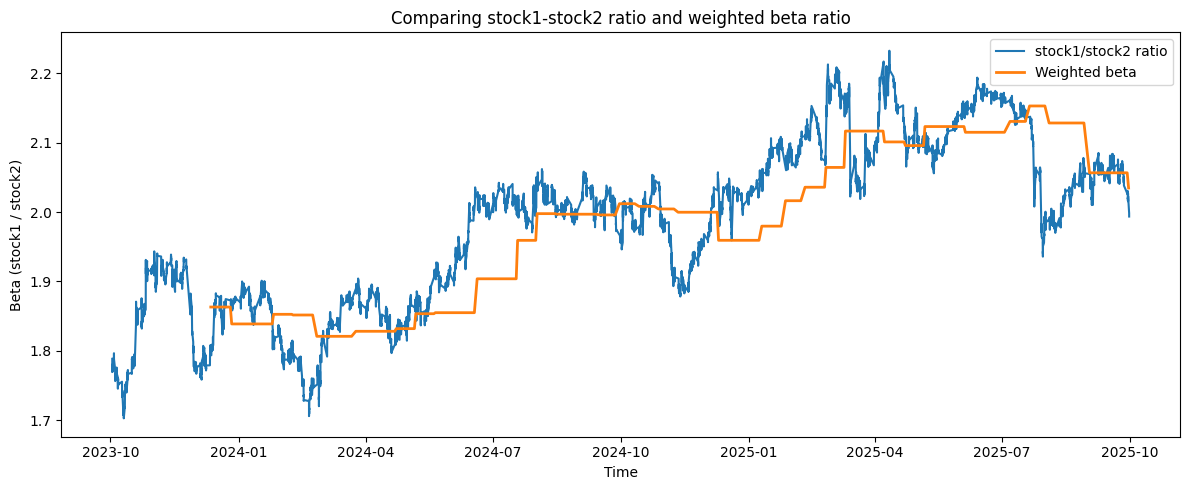

In [60]:
beta_direct = stock1/stock2

plt.figure(figsize=(12, 5))
plt.plot(beta_direct.index, beta_direct, label="stock1/stock2 ratio", linewidth=1.5)
plt.plot(weighted_beta.index, weighted_beta, label="Weighted beta", linewidth=2)

plt.title("Comparing stock1-stock2 ratio and weighted beta ratio")
plt.xlabel("Time")
plt.ylabel("Beta (stock1 / stock2)")
plt.legend()
plt.tight_layout()
plt.show()

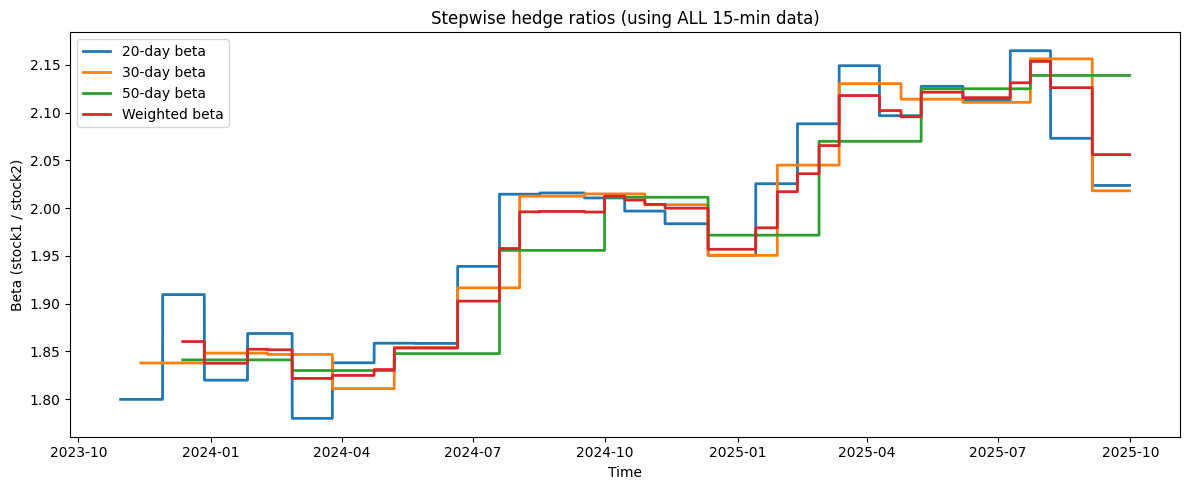

Beta window weightings : (0.3, 0.4, 0.3)


In [61]:
import numpy as np

ratio_15m = (stock1 / stock2).dropna()

# Robust bars/day inference (recommended)
BARS_PER_DAY = int(ratio_15m.groupby(ratio_15m.index.date).size().median())

def step_beta_intraday(ratio_15m, N_days):
    window = int(N_days * BARS_PER_DAY)

    beta_hat = ratio_15m.rolling(window).mean()

    mask = np.zeros(len(beta_hat), dtype=bool)
    mask[::window] = True  # rebalance every N days worth of bars

    # Shift by 1 bar to avoid "compute and trade on same bar"
    return beta_hat.where(mask).ffill().shift(1)

granular_beta_20 = step_beta_intraday(ratio_15m, 20)
granular_beta_30 = step_beta_intraday(ratio_15m, 30)
granular_beta_50 = step_beta_intraday(ratio_15m, 50)

granular_weighted_beta = granular_beta_20 * beta_weights[0] +  granular_beta_30 * beta_weights[1] + granular_beta_50 * beta_weights[2]

plt.figure(figsize=(12, 5))
plt.plot(granular_beta_20.index, granular_beta_20, label="20-day beta", linewidth=2)
plt.plot(granular_beta_30.index, granular_beta_30, label="30-day beta", linewidth=2)
plt.plot(granular_beta_50.index, granular_beta_50, label="50-day beta", linewidth=2)
plt.plot(granular_weighted_beta.index, granular_weighted_beta, label="Weighted beta", linewidth=2)

plt.title("Stepwise hedge ratios (using ALL 15-min data)")
plt.xlabel("Time")
plt.ylabel("Beta (stock1 / stock2)")
plt.legend()
plt.tight_layout()
plt.show()

print("Beta window weightings :", beta_weights)


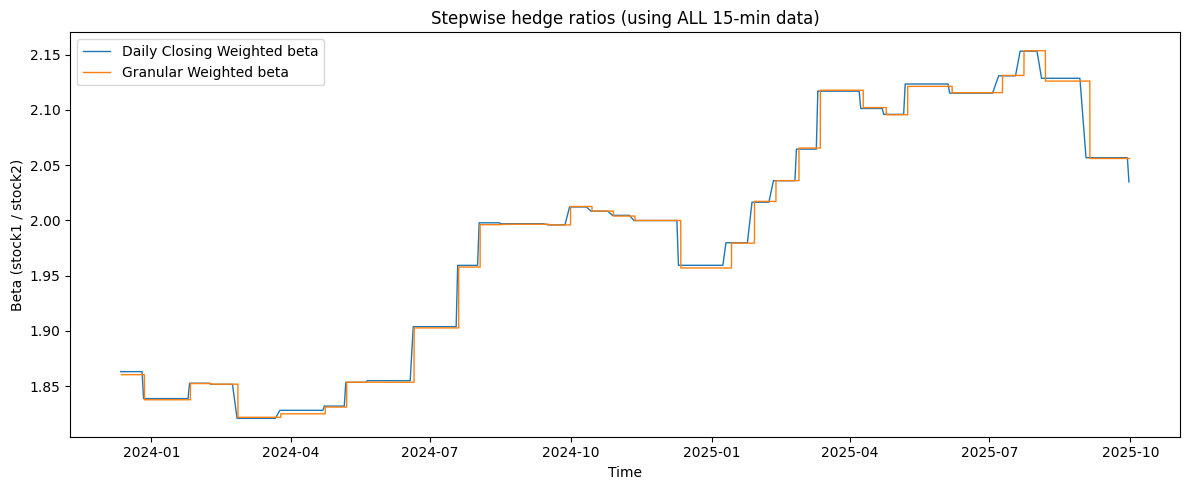

In [62]:
plt.figure(figsize=(12, 5))

plt.plot(weighted_beta.index, weighted_beta, label="Daily Closing Weighted beta", linewidth=1)
plt.plot(granular_weighted_beta.index, granular_weighted_beta, label="Granular Weighted beta", linewidth=1)

plt.title("Stepwise hedge ratios (using ALL 15-min data)")
plt.xlabel("Time")
plt.ylabel("Beta (stock1 / stock2)")
plt.legend()
plt.tight_layout()
plt.show()

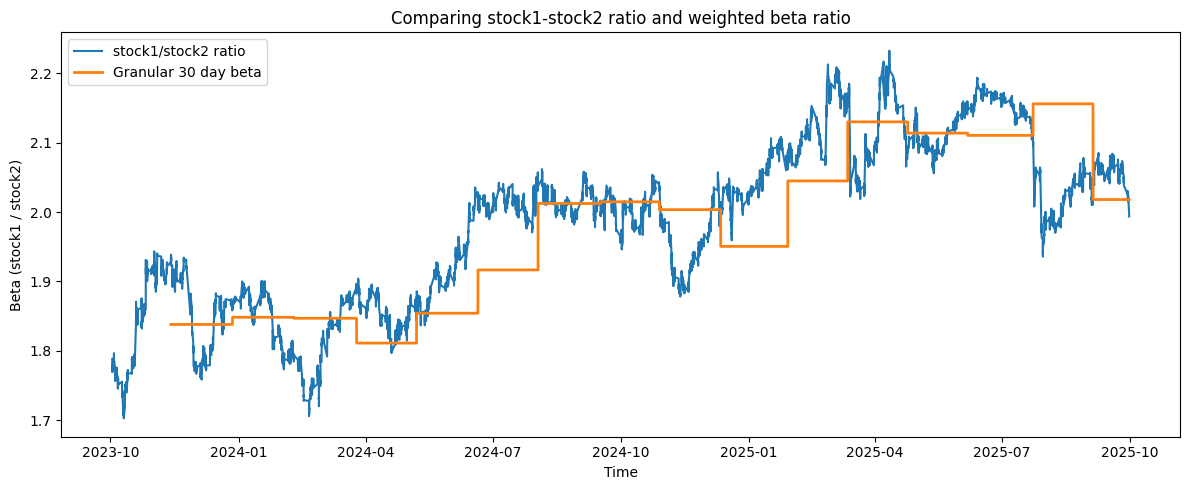

In [63]:

beta_direct = stock1/stock2

plt.figure(figsize=(12, 5))
plt.plot(beta_direct.index, beta_direct, label="stock1/stock2 ratio", linewidth=1.5)
plt.plot(granular_beta_30.index, granular_beta_30, label="Granular 30 day beta", linewidth=2)

plt.title("Comparing stock1-stock2 ratio and weighted beta ratio")
plt.xlabel("Time")
plt.ylabel("Beta (stock1 / stock2)")
plt.legend()
plt.tight_layout()
plt.show()

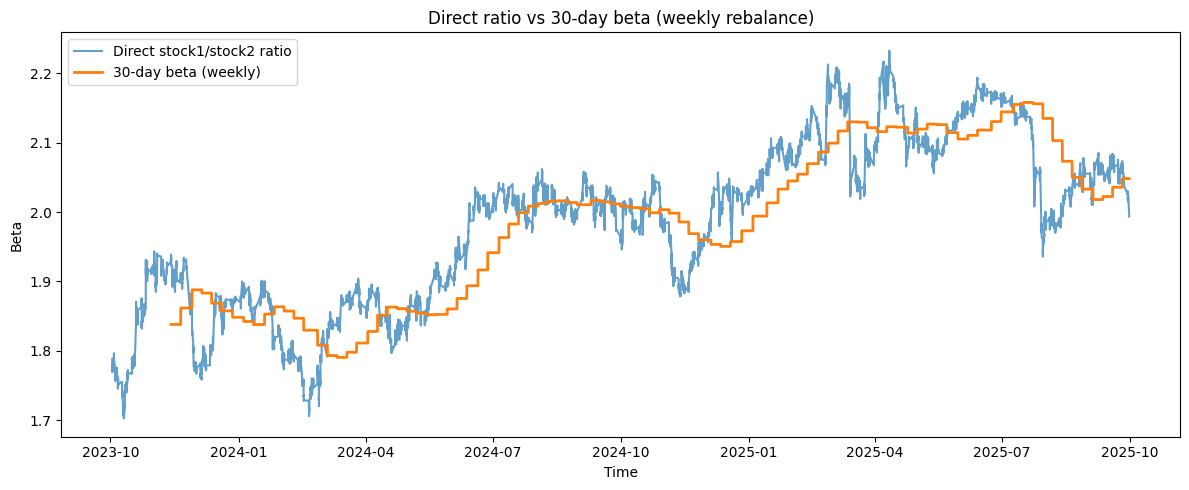

In [64]:
# 30 day beta calculation but beta re calculated weekly. 
# 15-min ratio
ratio_15m = (stock1 / stock2).dropna()

# how many 15-min bars in a trading day (infer from data)
BARS_PER_DAY = int(ratio_15m.groupby(ratio_15m.index.date).size().median())

# parameters
LOOKstock2K_DAYS = 30
REBALANCE_DAYS = 5   # weekly

lookstock2k = LOOKstock2K_DAYS * BARS_PER_DAY
rebalance = REBALANCE_DAYS * BARS_PER_DAY

# rolling 30-day average (uses ALL intraday bars)
beta_hat = ratio_15m.rolling(lookstock2k).mean()

# take beta once a week, hold in between
mask = np.zeros(len(beta_hat), dtype=bool)
mask[::rebalance] = True

beta_30_weekly = beta_hat.where(mask).ffill().shift(1)

plt.figure(figsize=(12, 5))
plt.plot(ratio_15m, label="Direct stock1/stock2 ratio", alpha=0.7)
plt.plot(beta_30_weekly, label="30-day beta (weekly)", linewidth=2)

plt.title("Direct ratio vs 30-day beta (weekly rebalance)")
plt.xlabel("Time")
plt.ylabel("Beta")
plt.legend()
plt.tight_layout()
plt.show()


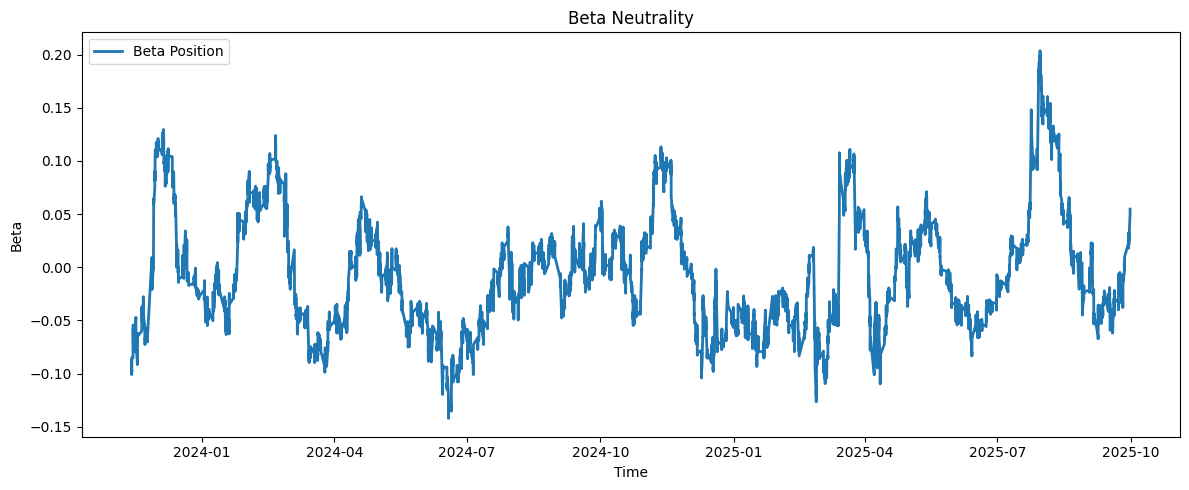

In [65]:
beta_neutrality = beta_30_weekly - ratio_15m
plt.figure(figsize=(12, 5))
plt.plot(beta_neutrality, label="Beta Position", linewidth=2)

plt.title("Beta Neutrality")
plt.xlabel("Time")
plt.ylabel("Beta")
plt.legend()
plt.tight_layout()
plt.show()


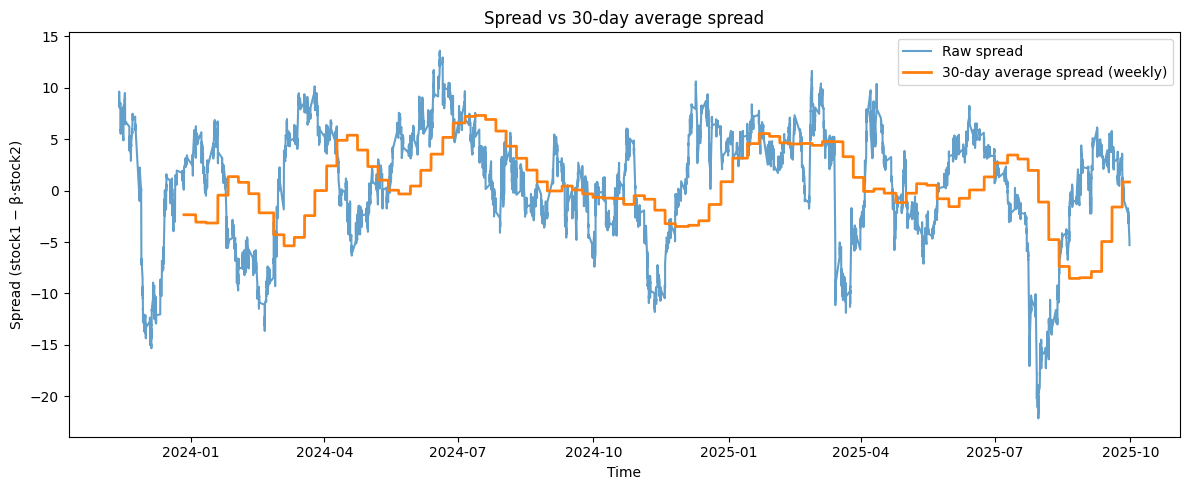

In [66]:
spread_15m = stock1 - beta_30_weekly * stock2

spread_mean_hat = spread_15m.rolling(lookstock2k).mean()

mask_spread = np.zeros(len(spread_mean_hat), dtype=bool)
mask_spread[::rebalance] = True

spread_mean_30_weekly = spread_mean_hat.where(mask_spread).ffill().shift(1)

plt.figure(figsize=(12, 5))
plt.plot(spread_15m, label="Raw spread", alpha=0.7)
plt.plot(spread_mean_30_weekly, label="30-day average spread (weekly)", linewidth=2)

plt.title("Spread vs 30-day average spread")
plt.xlabel("Time")
plt.ylabel("Spread (stock1 − β·stock2)")
plt.legend()
plt.tight_layout()
plt.show()


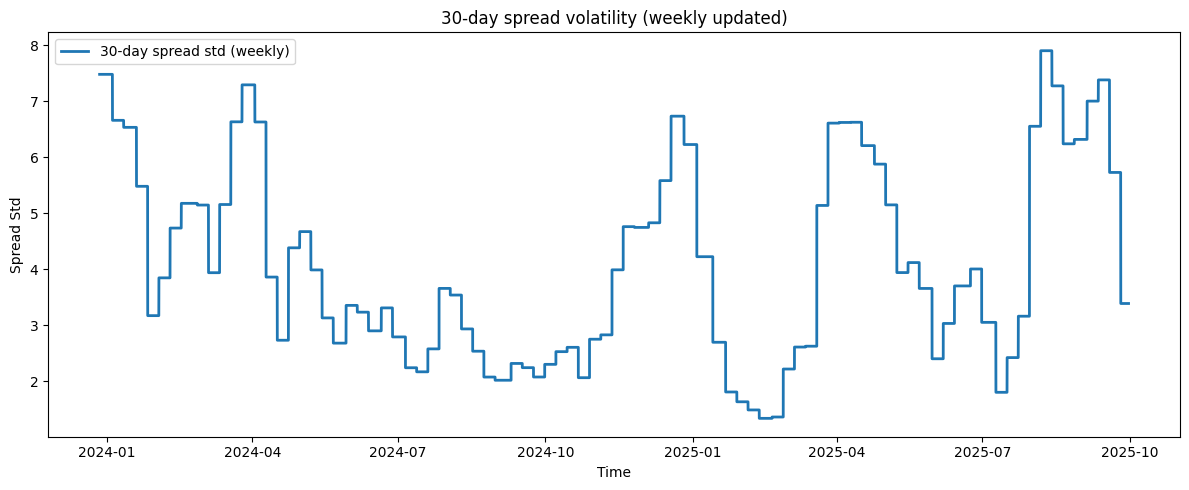

In [67]:
# Standard Deviation of Spread

spread_std_hat = spread_15m.rolling(lookstock2k).std()
mask_std = np.zeros(len(spread_std_hat), dtype=bool)
mask_std[::rebalance] = True

spread_std_30_weekly = spread_std_hat.where(mask_std).ffill().shift(1)

plt.figure(figsize=(12, 5))
plt.plot(spread_std_30_weekly, label="30-day spread std (weekly)", linewidth=2)

plt.title("30-day spread volatility (weekly updated)")
plt.xlabel("Time")
plt.ylabel("Spread Std")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/1y/yfz2g57x4c36b6s85dy_f84c0000gn/T/ipykernel_28144/273470080.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


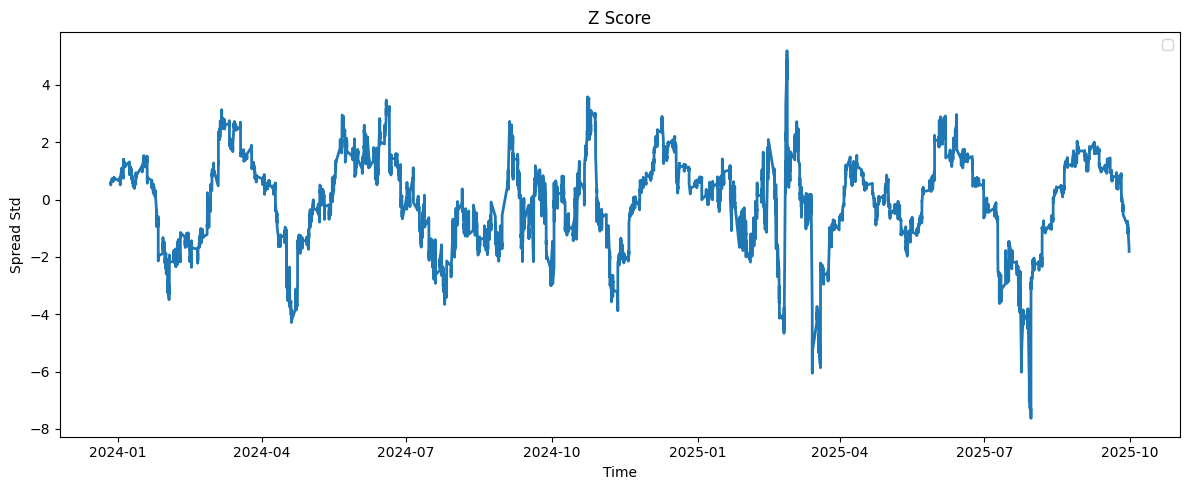

In [68]:
# Calculating Z Score
zscore = (spread_15m - spread_mean_30_weekly) / spread_std_30_weekly

plt.figure(figsize=(12, 5))
plt.plot(zscore, linewidth=2)

plt.title("Z Score")
plt.xlabel("Time")
plt.ylabel("Spread Std")
plt.legend()
plt.tight_layout()
plt.show()

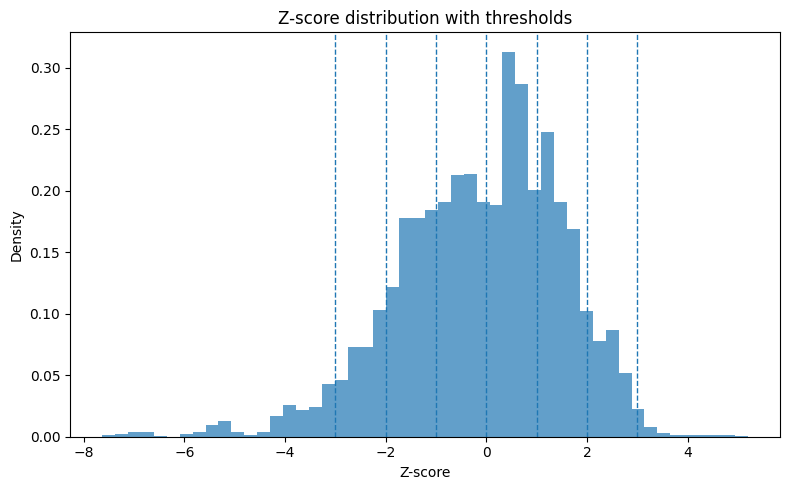

In [69]:
z = zscore.dropna()


plt.figure(figsize=(8, 5))

for v in [-3, -2, -1, 0, 1, 2, 3]:
    plt.axvline(v, linestyle="--", linewidth=1)

plt.hist(z, bins=50, density=True, alpha=0.7)


plt.title("Z-score distribution with thresholds")
plt.xlabel("Z-score")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [70]:
import pandas as pd
Z_ENTRY = 3.5
Z_EXIT  = 1
MAX_DRIFT_PCT = 6.5  # Skip entry if direct beta is more than 8% away from beta_entry

trades = []
skipped_trades = 0  # Track how many trades were skipped due to drift
in_trade = False
entry_idx = None
entry_time = None

for i in range(len(z)):
    zi = z.iloc[i]
    t = z.index[i]

    # ENTRY
    if (not in_trade) and (abs(zi) >= Z_ENTRY):
        entry_price_stock1 = float(stock1.loc[t])
        entry_price_stock2 = float(stock2.loc[t])
        beta_entry = float(beta_30_weekly.loc[t])
        
        # Calculate direct beta (actual ratio) at entry
        direct_beta = entry_price_stock1 / entry_price_stock2
        
        # Check delta drift: skip if direct beta is more than 8% away from beta_entry
        drift_pct = abs(100.0 * (direct_beta - beta_entry) / beta_entry)
        
        if drift_pct >= MAX_DRIFT_PCT:
            skipped_trades += 1
            continue  # Skip this entry
        
        in_trade = True
        entry_idx = i
        entry_time = t
        direction = "SHORT_SPREAD" if zi > 0 else "LONG_SPREAD"

    # EXIT
    elif in_trade and (abs(zi) <= Z_EXIT):
        exit_time = t
        exit_price_stock1 = float(stock1.loc[t])
        exit_price_stock2 = float(stock2.loc[t])

        beta_exit = float(beta_30_weekly.loc[t])
        beta_change_pct = 100.0 * (beta_exit - beta_entry) / beta_entry

        dJ = exit_price_stock1 - entry_price_stock1
        dB = exit_price_stock2 - entry_price_stock2

        if direction == "LONG_SPREAD":
            pnl = dJ - beta_entry * dB
        else:
            pnl = -dJ + beta_entry * dB

        trades.append({
            "direction": direction,
            "entry_time": entry_time,
            "exit_time": exit_time,
            "entry_price_stock1": entry_price_stock1,
            "exit_price_stock1": exit_price_stock1,
            "entry_price_stock2": entry_price_stock2,
            "exit_price_stock2": exit_price_stock2,
            "beta_entry": beta_entry,
            "beta_exit": beta_exit,
            "beta_change_pct": beta_change_pct,
            "entry_drift_pct": drift_pct,
            "holding_bars": int(i - entry_idx),
            "pnl": float(pnl),
        })

        in_trade = False
        entry_idx = None
        entry_time = None


# ---------------- PRINT TRADE LOG ----------------
trades_df = pd.DataFrame(trades)

print("len(z):", len(z))
print("max |z|:", float(z.abs().max()))
print("entries hit (|z|>=4):", int((z.abs() >= Z_ENTRY).sum()))
print("exits hit (|z|<=1):", int((z.abs() <= Z_EXIT).sum()))
print(f"entries skipped (drift >= {MAX_DRIFT_PCT}%):", skipped_trades)
print("trades generated:", len(trades))

if trades_df.empty:
    print("\nNO COMPLETED TRADES")
else:
    trades_df["holding_days"] = trades_df["holding_bars"] / BARS_PER_DAY

    # convert datetimes to strings so Jupyter *always* prints them
    for c in ["entry_time", "exit_time"]:
        trades_df[c] = trades_df[c].astype(str)

    print("\nTRADE LOG:")
    print(trades_df.to_string(index=False))

    print("\nTotal P&L:", trades_df["pnl"].sum())
    print("Avg P&L per trade:", trades_df["pnl"].mean())

len(z): 11381
max |z|: 7.631520583242662
entries hit (|z|>=4): 365
exits hit (|z|<=1): 5096
entries skipped (drift >= 6.5%): 0
trades generated: 8

TRADE LOG:
   direction                entry_time                 exit_time  entry_price_stock1  exit_price_stock1  entry_price_stock2  exit_price_stock2  beta_entry  beta_exit  beta_change_pct  entry_drift_pct  holding_bars        pnl  holding_days
 LONG_SPREAD 2024-04-17 10:15:00-04:00 2024-05-01 09:30:00-04:00              171.81             172.47               94.48              93.97    1.862918   1.856971        -0.319215         2.385399           257   1.610088      9.884615
 LONG_SPREAD 2024-07-25 09:45:00-04:00 2024-07-30 10:45:00-04:00              214.65             220.53              108.62             108.26    1.999207   2.008672         0.473406         1.153050            82   6.599715      3.153846
SHORT_SPREAD 2024-10-23 13:30:00-04:00 2024-10-29 09:30:00-04:00              226.20             215.44              110.18 

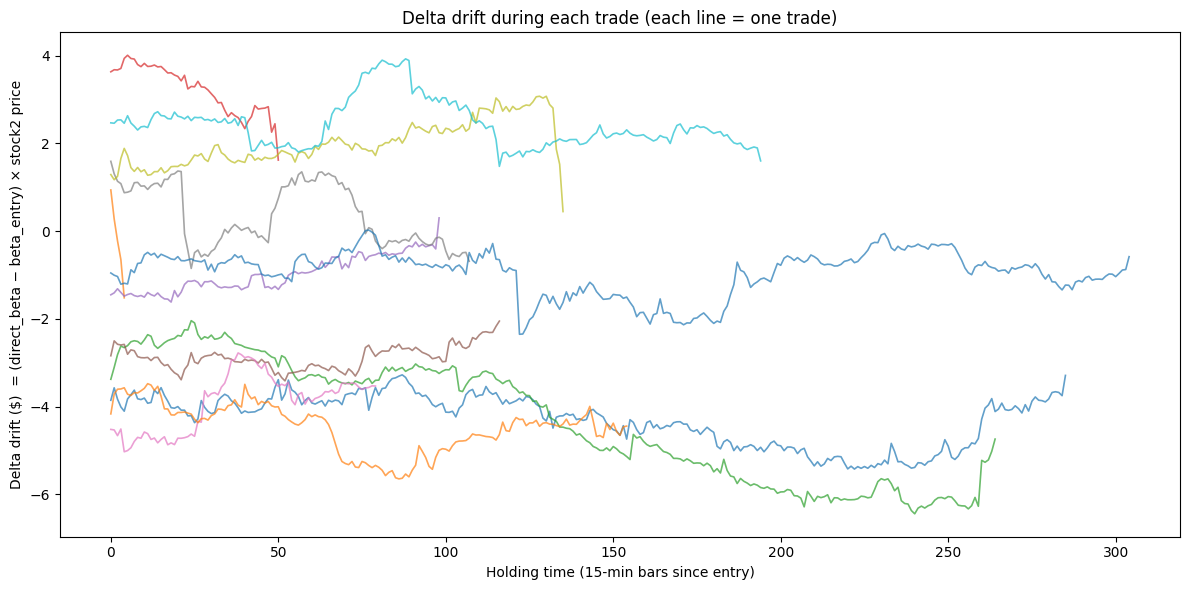

In [49]:

# direct beta at each bar (instantaneous neutrality)
direct_beta = (stock1 / stock2).dropna()

# Make sure everything aligns to the same index for slicing
direct_beta = direct_beta.reindex(stock2.index).dropna()

plt.figure(figsize=(12, 6))

for k, row in trades_df.reset_index(drop=True).iterrows():
    entry_t = row["entry_time"]
    exit_t  = row["exit_time"]
    beta_entry = row["beta_entry"]

    # slice the holding period (inclusive)
    idx = direct_beta.loc[entry_t:exit_t].index

    # per-bar drift (dollars per 1 stock1 hedged)
    drift = (direct_beta.loc[idx] - beta_entry) * stock2.loc[idx]

    # x-axis: elapsed holding time in bars (0,1,2,...)
    x = np.arange(len(drift))

    plt.plot(x, drift.values, linewidth=1.2, alpha=0.7)

plt.title("Delta drift during each trade (each line = one trade)")
plt.xlabel("Holding time (15-min bars since entry)")
plt.ylabel("Delta drift ($)  = (direct_beta − beta_entry) × stock2 price")
plt.tight_layout()
plt.show()


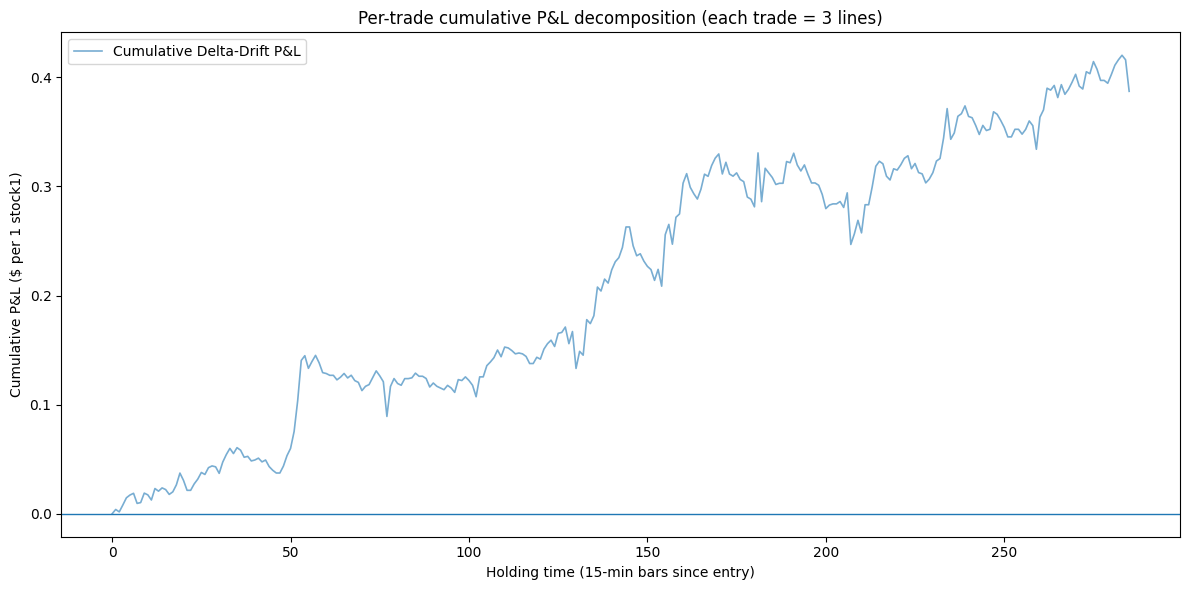

In [50]:

# direct beta at each bar (instantaneous neutrality)
direct_beta = (stock1 / stock2).reindex(stock2.index)

plt.figure(figsize=(12, 6))

first = True  # for legend labels only once

for _, row in trades_df.reset_index(drop=True).iterrows():
    entry_t = row["entry_time"]
    exit_t  = row["exit_time"]
    beta_entry = row["beta_entry"]

    # slice holding period
    stock1 = stock1.loc[entry_t:exit_t].dropna()
    stock2 = stock2.loc[entry_t:exit_t].reindex(stock1.index).dropna()
    db  = direct_beta.loc[stock1.index].dropna()

    # align all
    idx = stock1.index.intersection(stock2.index).intersection(db.index)
    stock1 = stock1.loc[idx]
    stock2 = stock2.loc[idx]
    db  = db.loc[idx]

    # per-bar price changes
    dstock1 = stock1.diff()
    dstock2 = stock2.diff()

    # 1) total P&L per bar (per 1 stock1 hedged with beta_entry stock2)
    total_pnl_bar = dstock1 - beta_entry * dstock2

    # 2) delta-drift P&L per bar (no lookahead)
    drift_pnl_bar = (db.shift(1) - beta_entry) * dstock2

    # 3) spread P&L per bar
    spread_pnl_bar = total_pnl_bar - drift_pnl_bar

    # cumulative within the trade (start at 0)
    cum_total  = total_pnl_bar.fillna(0).cumsum()
    cum_drift  = drift_pnl_bar.fillna(0).cumsum()
    cum_spread = spread_pnl_bar.fillna(0).cumsum()

    # elapsed time axis
    x = np.arange(len(idx))

    # plot (labels only once)
    #plt.plot(x, cum_total.values,  linewidth=1.2, alpha=0.6,
             #label="Cumulative Total P&L" if first else None)
    plt.plot(x, cum_drift.values,  linewidth=1.2, alpha=0.6,
             label="Cumulative Delta-Drift P&L" if first else None)
    #plt.plot(x, cum_spread.values, linewidth=1.2, alpha=0.6,
             #label="Cumulative Spread P&L (Total − Drift)" if first else None)

    first = False

plt.axhline(0, linewidth=1)
plt.title("Per-trade cumulative P&L decomposition (each trade = 3 lines)")
plt.xlabel("Holding time (15-min bars since entry)")
plt.ylabel("Cumulative P&L ($ per 1 stock1)")
plt.legend()
plt.tight_layout()
plt.show()
